In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

from misc import HUF_TOKEN
from misc import ALL_ASSIGNMENTS_PATHS, ALL_N_CLUSTERS, FILTER_PATH

from dataset import load_comparison_dataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D, _, _, _, _ = load_comparison_dataset(token=HUF_TOKEN)

INFO:dataset:Loading arena_human_preference_140k dataset...


In [3]:
all_assignments = [np.load(path) for path in ALL_ASSIGNMENTS_PATHS]

In [4]:
class ClusteredBradleyTerryModel(nn.Module):
    def __init__(
            self,
            n_items: int,
            n_clusters: int,
            advantage: bool = False,
            reg: float = 1e-2,
    ):
        super(ClusteredBradleyTerryModel, self).__init__()
        self.n_items = n_items
        self.n_clusters = n_clusters
        self.reg = reg
        self.advantage = advantage

        # Bradley-Terry for item-item preferences
        self.bt_item_popularity = nn.Parameter(torch.zeros(n_clusters, n_items))

        # Per-cluster advantage terms
        if advantage:
            self.bt_adv = nn.Parameter(torch.zeros(n_clusters,))

    def predict_proba(
            self,
            cluster_indices,
            item_i_indices,
            item_j_indices,
    ):
        H = self.forward(
            cluster_indices,
            item_i_indices,
            item_j_indices,
        )
        pj = torch.sigmoid(H)
        pi = 1 - pj
        return torch.stack([pi, pj], dim=1)
    
    def forward(
            self,
            cluster_indices,
            item_i_indices,
            item_j_indices,
    ):
        Z_i = self.bt_item_popularity[cluster_indices, item_i_indices]
        Z_j = self.bt_item_popularity[cluster_indices, item_j_indices]  # (n_samples,)
        H = Z_j - Z_i

        if self.advantage:
            H += self.bt_adv[cluster_indices]

        return H
    
    def loss(
            self,
            cluster_indices,
            item_i_indices,
            item_j_indices,
            y,
    ):
        # Log likelihoods
        H = self.forward(
            cluster_indices,
            item_i_indices,
            item_j_indices,
        )
        bt_loss = F.binary_cross_entropy_with_logits(H, y)

        # Regularization
        reg_loss = self.reg * (
            self.bt_item_popularity.norm(p=2).abs()
        ) / self.n_clusters

        return bt_loss + reg_loss

In [5]:
def fit_cluster_bt(
        cluster_indices: torch.Tensor,
        item_i_indices: torch.Tensor,
        item_j_indices: torch.Tensor,
        y: torch.Tensor,
        bt_max_steps: int = 1000,
        progress_bar: bool = True,
        advantage: bool = False,
):
    n_items = max(item_i_indices.max(), item_j_indices.max()).item() + 1
    assignments = cluster_indices
    n_clusters = cluster_indices.max() + 1

    # Initialize Bradley-Terry model
    model = ClusteredBradleyTerryModel(
        n_items=n_items,
        n_clusters=n_clusters,
        advantage=advantage,
    ).to(item_i_indices.device)

    # Fit Bradley-Terry parameters
    optimizer = torch.optim.LBFGS(model.parameters(), max_iter=bt_max_steps, line_search_fn="strong_wolfe", tolerance_grad=1e-09)

    if progress_bar:
        prog = tqdm(range(bt_max_steps), desc="Fitting BT parameters")

    def closure():
        optimizer.zero_grad()
        loss = model.loss(
            assignments[assignments >= 0],
            item_i_indices[assignments >= 0],
            item_j_indices[assignments >= 0],
            y[assignments >= 0],
        )
        loss.backward()
        if progress_bar:
            prog.update(1)
            prog.set_postfix(loss=loss.item())
        return loss
    
    optimizer.step(closure)

    if progress_bar:
        prog.close()

    return model

In [6]:
m = max(D["item_i_indices"].max(), D["item_j_indices"].max()).item() + 1
item_i_indices = D["item_i_indices"]
item_j_indices = D["item_j_indices"]
y = D["y"]

def get_pref_matrix(model):
    P = torch.zeros((n_clusters, m, m))
    for c in range(n_clusters):
        item_indices = torch.arange(m)
        cluster_indices = torch.full((m * m,), c, dtype=torch.long)
        item_j_expanded = item_indices.repeat_interleave(m)
        item_i_expanded = item_indices.repeat(m)
        P_c = model.predict_proba(
            cluster_indices,
            item_i_expanded,
            item_j_expanded,
        )[:, 1].view(m, m)
        P[c] = P_c
    return P.detach().numpy()

P0s = []
P1s = []
for n_clusters, assignments in zip(ALL_N_CLUSTERS, all_assignments):
    print(f"Processing n_clusters={n_clusters}...")
    model_0 = fit_cluster_bt(
        cluster_indices=torch.tensor(assignments, dtype=torch.long),
        item_i_indices=D["item_i_indices"],
        item_j_indices=D["item_j_indices"],
        y=D["y"],
        advantage=False,
    )
    model_1 = fit_cluster_bt(
        cluster_indices=torch.tensor(assignments, dtype=torch.long),
        item_i_indices=D["item_i_indices"],
        item_j_indices=D["item_j_indices"],
        y=D["y"],
        advantage=True,
    )
    P0s.append(get_pref_matrix(model_0))
    P1s.append(get_pref_matrix(model_1))

Processing n_clusters=1...


Fitting BT parameters:   2%|▏         | 19/1000 [00:00<00:29, 33.56it/s, loss=0.671]


Processing n_clusters=2...


Fitting BT parameters:   2%|▏         | 18/1000 [00:00<00:25, 39.23it/s, loss=0.664]


Processing n_clusters=4...


Fitting BT parameters:   3%|▎         | 32/1000 [00:00<00:19, 50.16it/s, loss=0.658]


Processing n_clusters=8...


Fitting BT parameters:   4%|▍         | 40/1000 [00:00<00:19, 49.36it/s, loss=0.652]


Processing n_clusters=16...


Fitting BT parameters:   4%|▍         | 45/1000 [00:00<00:13, 68.41it/s, loss=0.645]


Processing n_clusters=32...


Fitting BT parameters:   6%|▌         | 60/1000 [00:00<00:12, 74.89it/s, loss=0.638]


Processing n_clusters=64...


Fitting BT parameters:   7%|▋         | 72/1000 [00:00<00:09, 100.72it/s, loss=0.628]


Processing n_clusters=128...


Fitting BT parameters:  10%|█         | 104/1000 [00:01<00:08, 103.16it/s, loss=0.606]


Processing n_clusters=256...


Fitting BT parameters:  12%|█▏        | 123/1000 [00:01<00:08, 102.36it/s, loss=0.568]


Processing n_clusters=512...


Fitting BT parameters:  22%|██▏       | 219/1000 [00:01<00:06, 116.23it/s, loss=0.481]


Processing n_clusters=1024...


Fitting BT parameters:  40%|████      | 403/1000 [00:11<00:16, 35.19it/s, loss=0.325]


In [7]:
# get MLEs of preference matrices
PSs = []
for n_clusters, assignments in zip(ALL_N_CLUSTERS, all_assignments):
    assignments = torch.tensor(assignments, dtype=torch.long)
    W = torch.zeros((n_clusters, m, m))
    L = torch.zeros((n_clusters, m, m))
    W.index_put_((assignments, item_i_indices, item_j_indices), (y == 0.0).float(), accumulate=True)
    L.index_put_((assignments, item_i_indices, item_j_indices), (y == 1.0).float(), accumulate=True)
    PS = (W + L.transpose(1, 2)) / (W + W.transpose(1, 2) + + L + L.transpose(1, 2) + 1e-8)
    PS = PS.numpy()
    PSs.append(PS)

In [8]:
# compute per-cluster log-likelihoods
def pref_loglik(P, n_clusters, assignments):
    loglik = []
    for c in range(n_clusters):
        cluster_filt = (assignments == c)
        y_clust = y[cluster_filt].numpy()
        p_clust = P[c, item_j_indices[cluster_filt].numpy(), item_i_indices[cluster_filt].numpy()]
        loglik.append((y_clust * np.log(p_clust + 1e-8) + (1 - y_clust) * np.log(1 - p_clust + 1e-8)).sum())
    return np.array(loglik) 

ll0s = []
ll1s = []
llSs = []
for n_clusters, assignments, P0, P1, PS in zip(ALL_N_CLUSTERS, all_assignments, P0s, P1s, PSs):
    ll0 = pref_loglik(P0, n_clusters, assignments)
    ll1 = pref_loglik(P1, n_clusters, assignments)
    llS = pref_loglik(PS, n_clusters, assignments)
    ll0s.append(ll0)
    ll1s.append(ll1)
    llSs.append(llS)

ll0s[-1].mean(), ll1s[-1].mean(), llSs[-1].mean()

(-31.232523, -30.141815, -4.0656557)

In [9]:
# estimate 95% chi-squared threshold
from scipy.stats import chi2
chi2_threshold_0v1 = chi2.ppf(0.95, df=1)
chi2_threshold_0vS = chi2.ppf(0.95, df=m*(m-3)/2)
chi2_threshold_0v1, chi2_threshold_0vS

(3.8414588206941205, 1358.1498427367903)

In [10]:
# compute per-cluster likelihood ratio statistics
lr_0v1s = []
lr_0vSs = []
for ll0, ll1, lls in zip(ll0s, ll1s, llSs):
    lr_0v1 = 2 * (ll1 - ll0)
    lr_0vS = 2 * (lls - ll0)
    lr_0v1s.append(lr_0v1)
    lr_0vSs.append(lr_0vS)
(lr_0v1s[-1] > chi2_threshold_0v1).mean(), (lr_0vSs[-1] > chi2_threshold_0vS).mean()

(0.1953125, 0.0)

In [11]:
T_0vS_color = "#7EC8E3"
T_0v1_color = "#FF7F0E"

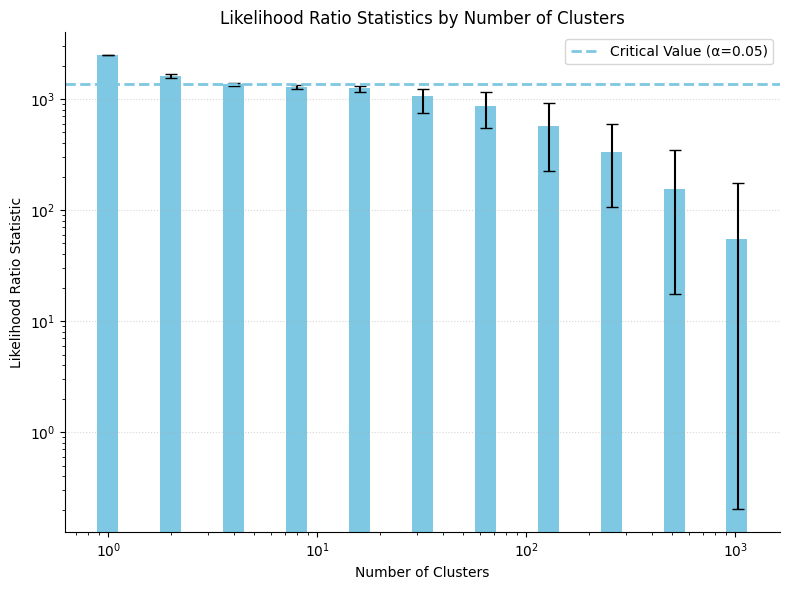

In [12]:
means = np.array([np.mean(b) for b in lr_0vSs])
ci_low = np.array([np.percentile(b, 2.5) for b in lr_0vSs])
ci_high = np.array([np.percentile(b, 97.5) for b in lr_0vSs])
yerr = np.vstack([means - ci_low, ci_high - means])

fig, ax = plt.subplots(figsize=(8, 6))

log_x = np.log10(ALL_N_CLUSTERS)
log_width = 0.1

left  = 10 ** (log_x - log_width/2)
right = 10 ** (log_x + log_width/2)
bar_widths = right - left

ax.bar(
    ALL_N_CLUSTERS,
    means,
    yerr=yerr,
    color=T_0vS_color,
    edgecolor="none",
    capsize=4,
    width=bar_widths,
)

ax.axhline(
    y=chi2_threshold_0vS,
    color=T_0vS_color,
    linestyle="--",
    linewidth=2,
    label="Critical Value (α=0.05)",
)

ax.set_xticks(ALL_N_CLUSTERS)
ax.set_xticklabels([str(c) for c in ALL_N_CLUSTERS])

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Likelihood Ratio Statistic")
ax.set_title("Likelihood Ratio Statistics by Number of Clusters")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

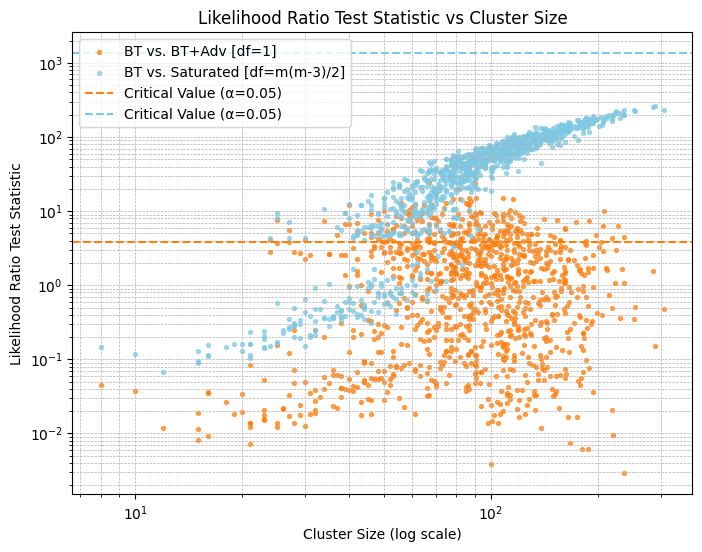

In [13]:
cluster_sizes = (assignments[:, None] == torch.arange(n_clusters)).sum(dim=0).numpy()
plt.figure(figsize=(8, 6))
plt.scatter(cluster_sizes[1:], lr_0v1s[-1][1:], alpha=0.7, label="BT vs. BT+Adv [df=1]", s=8, color=T_0v1_color)
plt.scatter(cluster_sizes[1:], lr_0vSs[-1][1:], alpha=0.7, label="BT vs. Saturated [df=m(m-3)/2]", s=8, color=T_0vS_color)

# Add horizontal line for critical value
plt.axhline(y=chi2_threshold_0v1, linestyle='--', label='Critical Value (α=0.05)', color=T_0v1_color)
plt.axhline(y=chi2_threshold_0vS, linestyle='--', label='Critical Value (α=0.05)', color=T_0vS_color)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Cluster Size (log scale)")
plt.legend()
plt.ylabel("Likelihood Ratio Test Statistic")
plt.title("Likelihood Ratio Test Statistic vs Cluster Size")
plt.grid(True, which="both", ls="--", linewidth=0.5)

In [14]:
def bt_fisher_information_trace(
    theta: torch.Tensor,
    item_i_indices: torch.Tensor,
    item_j_indices: torch.Tensor,
) -> torch.Tensor:
    theta = theta.to(dtype=torch.float64)
    i = item_i_indices.long()
    j = item_j_indices.long()

    delta = theta[i] - theta[j]
    p = torch.sigmoid(delta)
    w = p * (1.0 - p)
    return 2.0 * w.sum()

n_clusters = ALL_N_CLUSTERS[-1]
assignments = all_assignments[-1]
model_0 = fit_cluster_bt(
    cluster_indices=torch.tensor(assignments, dtype=torch.long),
    item_i_indices=D["item_i_indices"],
    item_j_indices=D["item_j_indices"],
    y=D["y"],
    advantage=False,
)
theta = model_0.bt_item_popularity.detach()

I = []
for c in range(n_clusters):
    cluster_filt = (assignments == c)
    item_i_clust = item_i_indices[cluster_filt]
    item_j_clust = item_j_indices[cluster_filt]
    I_c = bt_fisher_information_trace(
        theta[c],
        item_i_clust,
        item_j_clust,
    )
    I.append(I_c.item())
I = np.array(I)
I.min(), np.median(I), I.max()

Fitting BT parameters:  20%|██        | 202/1000 [00:04<00:19, 40.65it/s, loss=0.336]


(0.06738861170841358, 17.549392182693435, 110.00723288744825)

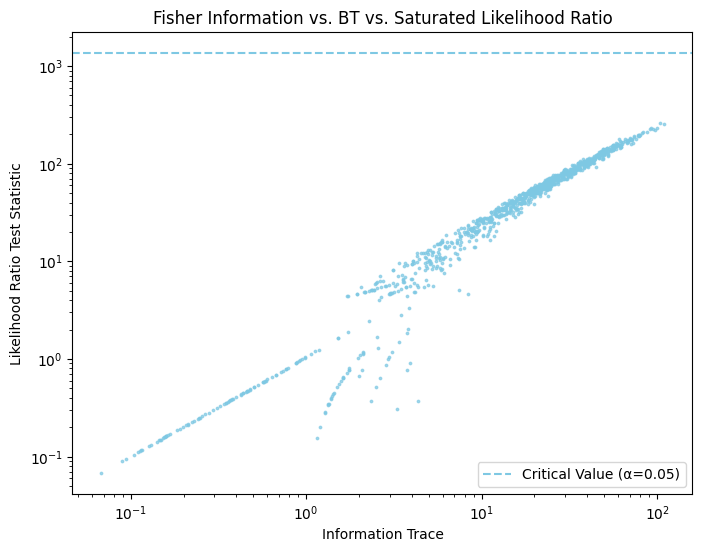

In [15]:
# Plot Fisher information vs. 0 vs S likelihood ratio statistic
lr_0vS = lr_0vSs[-1]
plt.figure(figsize=(8, 6))
plt.scatter(I, lr_0vS, color=T_0vS_color, s=3, alpha=0.7)
plt.axhline(y=chi2_threshold_0vS, linestyle='--', label='Critical Value (α=0.05)', color=T_0vS_color)
plt.xlabel("Information Trace")
plt.ylabel("Likelihood Ratio Test Statistic")
plt.yscale("log")
plt.xscale("log")
plt.title("Fisher Information vs. BT vs. Saturated Likelihood Ratio")
plt.legend()
plt.show()

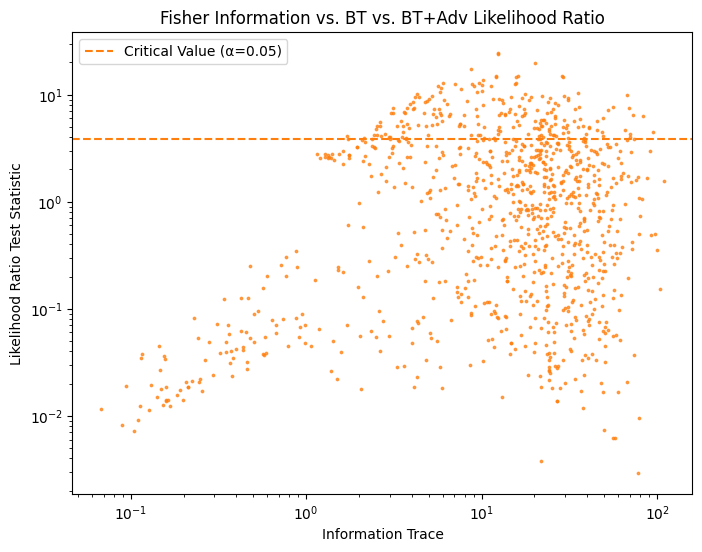

In [16]:
lr_0v1 = lr_0v1s[-1]
plt.figure(figsize=(8, 6))
plt.scatter(I, lr_0v1, color=T_0v1_color, s=3, alpha=0.7)
plt.axhline(y=chi2_threshold_0v1, linestyle='--', label='Critical Value (α=0.05)', color=T_0v1_color)
plt.xlabel("Information Trace")
plt.ylabel("Likelihood Ratio Test Statistic")
plt.yscale("log")
plt.xscale("log")
plt.title("Fisher Information vs. BT vs. BT+Adv Likelihood Ratio")
plt.legend()
plt.show()

In [17]:
n_clusters = ALL_N_CLUSTERS[-1]
I = I
lr_0v1 = lr_0v1s[-1]
lr_0vS = lr_0vSs[-1]
filt = (I >= 1) & (lr_0v1 <= chi2_threshold_0v1) & (lr_0vS <= 1.2)
np.save(FILTER_PATH, filt)
print(f"Filtering to {filt.sum()} homogeneous clusters, from {n_clusters} total")

Filtering to 39 homogeneous clusters, from 1024 total


In [18]:
from misc import TOPICS_PATH
import json

topics = [""] * n_clusters
with open(TOPICS_PATH, "r") as f:
    for line in f:
        entry = json.loads(line)
        cluster_idx = entry["gid"]
        topic = entry["topic"]
        topics[cluster_idx] = topic

np.random.seed(0)
homogeneous_cluster_indices = np.where(filt)[0]
heterogeneous_cluster_indices = np.where(~filt)[0]
sampled_homogeneous_cluster_indices = np.random.choice(
    homogeneous_cluster_indices,
    size=min(10, len(homogeneous_cluster_indices)),
    replace=False,
)
sampled_heterogeneous_cluster_indices = np.random.choice(
    heterogeneous_cluster_indices,
    size=min(10, len(heterogeneous_cluster_indices)),
    replace=False,
)

print(f"Sampled homogeneous cluster topics: {[topics[i] for i in sampled_homogeneous_cluster_indices]}")
print(f"Sampled heterogeneous cluster topics: {[topics[i] for i in sampled_heterogeneous_cluster_indices]}")

Sampled homogeneous cluster topics: ['Police and Crime', 'Programming Errors', 'Spain Finance', 'Text Encoding', 'Cultural and Religious Practices', 'API Integration', 'Polish Greetings', 'Artificial Intelligence', 'Audio Programming', 'Sports tournaments']
Sampled heterogeneous cluster topics: ['Mathematics', 'Top Rankings', 'File Management', 'Drugs and Dosages', 'Website Development', 'Relationship struggles', 'Programming Assistance', 'Database Design', 'Creative video scripting', 'Exam Preparation']


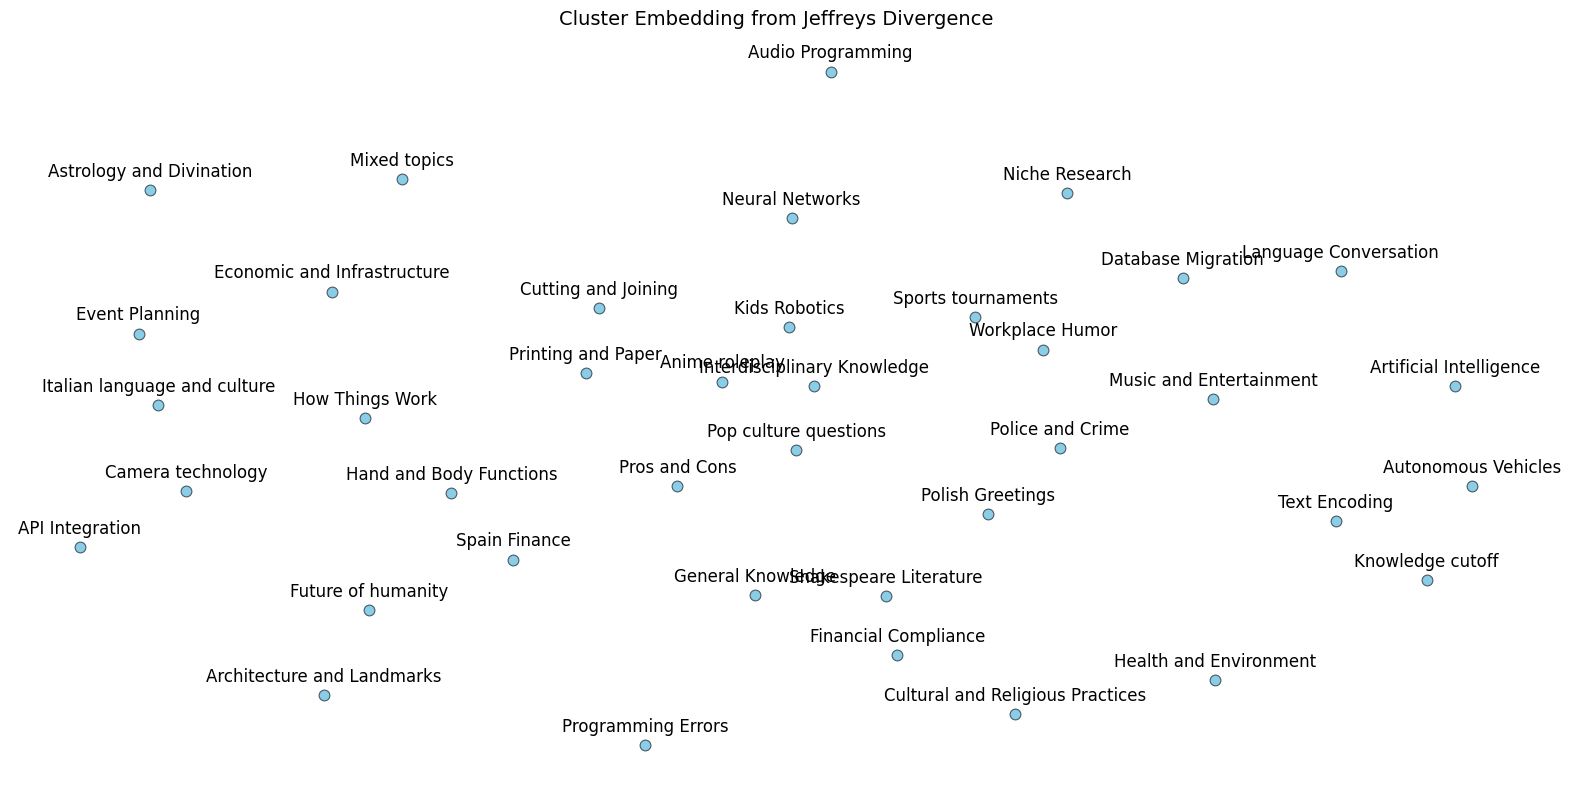

In [19]:
from scipy.special import expit
from sklearn.manifold import MDS

def expected_conditional_J(theta_p, theta_q):
    """Expected conditional Jeffreys divergence between two BT models."""
    Lp = theta_p[:, None] - theta_p[None, :]
    Lq = theta_q[:, None] - theta_q[None, :]
    P = expit(Lp)
    Q = expit(Lq)
    J = (P - Q) * (Lp - Lq)
    iu = np.triu_indices_from(J, k=1)
    return np.mean(J[iu])

def pairwise_divergence_matrix(thetas):
    C = len(thetas)
    D = np.zeros((C, C))
    for i in range(C):
        for j in range(i + 1, C):
            d = expected_conditional_J(thetas[i], thetas[j])
            D[i, j] = D[j, i] = d
    return D

def embed_clusters_from_divergence(D, n_components=2, random_state=0):
    mds = MDS(n_components=n_components, dissimilarity='precomputed',
              random_state=random_state)
    return mds.fit_transform(D)   # (C, 2)

def plot_cluster_embedding(coords, topics):
    coords = np.asarray(coords)
    x, y = coords[:, 0], coords[:, 1]

    _, ax = plt.subplots(figsize=(16, 8))

    # Points with your theme color
    ax.scatter(x, y, s=60, alpha=0.9,
               edgecolors="#3A4A5A", linewidths=0.8,
               color="#7EC8E3")

    # Vertical offset so text is above points, not on top
    y_span = y.max() - y.min() if y.max() > y.min() else 1.0
    y_off = 0.015 * y_span  # 0.8% of span

    for i, txt in enumerate(topics):
        ax.text(
            x[i], y[i] + y_off,
            txt,
            fontsize=12,
            ha="center",
            va="bottom",
        )

    ax.set_title("Cluster Embedding from Jeffreys Divergence", fontsize=14, pad=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.tight_layout()
    plt.show()

bt_params = model_0.bt_item_popularity.detach().cpu().numpy()[homogeneous_cluster_indices]
D = pairwise_divergence_matrix(bt_params)
coords = embed_clusters_from_divergence(D)
plot_cluster_embedding(coords, [topics[c] for c in homogeneous_cluster_indices])

In [20]:
from misc import load_embeddings

emb = load_embeddings()
centers = []
for c in homogeneous_cluster_indices:
    center = emb[assignments == c].mean(axis=0)
    centers.append(center)

x = []
y = []
for i in range(len(centers)):
    for j in range(i + 1, len(centers)):
        sim = F.cosine_similarity(
            torch.tensor(centers[i]).unsqueeze(0),
            torch.tensor(centers[j]).unsqueeze(0),
        ).item()
        x.append(D[i, j])
        y.append(sim)

In [23]:
# Compute R squared
x_np = np.array(x)
y_np = np.array(y)
correlation_matrix = np.corrcoef(x_np, y_np)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2
print(f"R squared between divergence and embedding similarity: {r_squared:.4f}")

R squared between divergence and embedding similarity: 0.0024


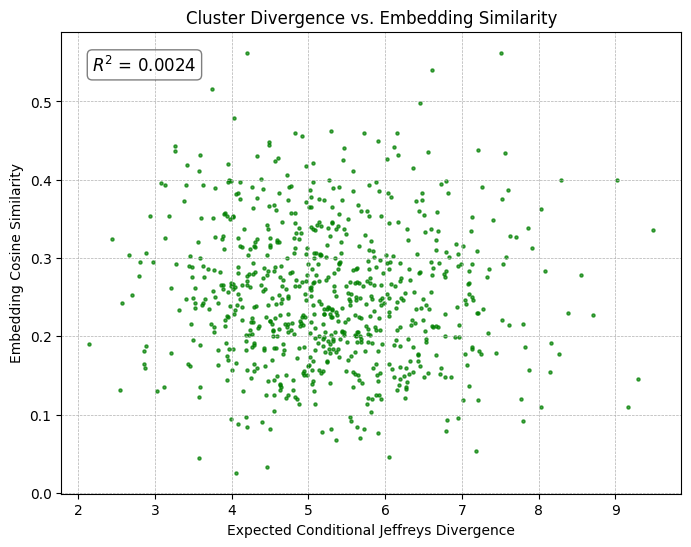

In [25]:
# Plot divergence vs. embedding similarity
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color="green", s=5, alpha=0.7)

# Add R squared annotation
plt.text(0.05, 0.95, f"$R^2$ = {r_squared:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

plt.xlabel("Expected Conditional Jeffreys Divergence")
plt.ylabel("Embedding Cosine Similarity")
plt.title("Cluster Divergence vs. Embedding Similarity")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()